In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint # solves the ODE and works with autograd

In [18]:
class VelocityFieldNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        # t is a scalar, so we need to expand it to match the batch size of x
        t_expanded = t.expand_as(x[:, :1])
        x = torch.cat([x, t_expanded], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def bicubic_interpolation(image, coords):
    """
    Perform bicubic interpolation on the image at the given coordinates.
    :param image: Tensor of shape (C, H, W)
    :param coords: Tensor of shape (N, 2) where N is the number of coordinates
    :return: Interpolated values at the coordinates

    Assumes image domain is on [-1,1]
    """
    grid = coords.unsqueeze(0).unsqueeze(0)  # Reshape for grid_sample
    interpolated = nn.functional.grid_sample(image.unsqueeze(0), grid, mode='bicubic', align_corners=True)
    return interpolated.squeeze()

def loss_function(v_net, x, CR,CT):
    """
    In the forward pass: 
    1. Approximate the terminal solution to the ODE to get transformation
    2. Use that solution to approximate the inverse transformation
    3. Evaluate the transformed template image using inverse sampling
    4. Compute loss
    """
    gridsize = int(x.shape[0] ** (1/2))
    # Solve the ODE
    def odefunc(t, z):
        return v_net(z, t)
    t = torch.tensor([0.0, 1.0])  # Assuming T=1
    z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1
    # Solve the inverse ODE
    def inv_odefunc(t, z):
        return -v_net(z, t)
    z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
    CT_z_inv_T = bicubic_interpolation(CT, z_inv_T).view(1, gridsize, gridsize).transpose(1,2)
    CR_x = bicubic_interpolation(CR, x).view(1, gridsize, gridsize).transpose(1,2)
    loss = 0.5 * torch.mean((CT_z_inv_T - CR_x) ** 2)
    return loss

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(root='../mnist_data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8813585.78it/s] 


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 471763.64it/s]


Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 936632.03it/s] 


Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2282047.05it/s]

Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw



In [14]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

# Taken from torchvision documentation

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

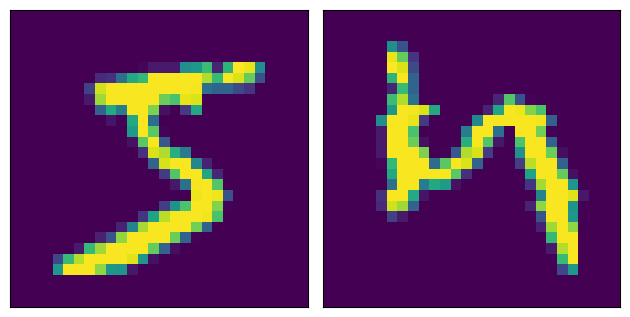

In [21]:
img,_ = train_dataset[0]
rotater = transforms.RandomRotation(degrees=(0,180))
rotated_img = rotater(img)
imgs = [img, rotated_img]
plot(imgs)

#images have shape 1,28,28

torch.Size([2500, 2])
784


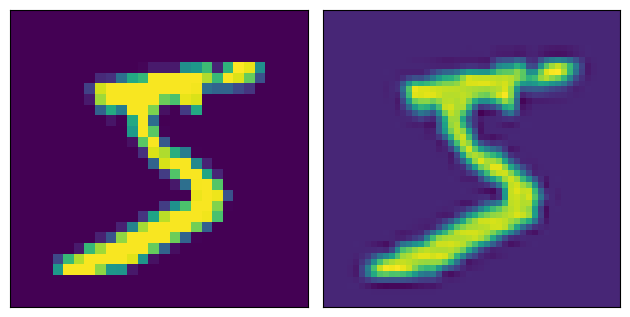

In [23]:
# Relabel
CR = img
CT = rotated_img
gridsize = 50
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

print(x.shape)
print(28*28)
test = bicubic_interpolation(CR, x).view(1,gridsize,gridsize).transpose(1,2)

plot([CR, test])

In [24]:
gridsize = 50
# Make grid
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

# Relabel
CR = img
CT = rotated_img

input_dim = 3  # (x, y, t) for 2D image
hidden_dim = 64
output_dim = 2  # (vx, vy) for 2D velocity field
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(v_net.parameters(), lr=0.01)

num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    loss = loss_function(v_net, x, CR, CT)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.09943493455648422
Epoch 1, Loss: 0.07003013789653778
Epoch 2, Loss: 0.06523536890745163
Epoch 3, Loss: 0.05737157538533211
Epoch 4, Loss: 0.05534495785832405
Epoch 5, Loss: 0.05401414632797241
Epoch 6, Loss: 0.05560843646526337
Epoch 7, Loss: 0.05458373948931694
Epoch 8, Loss: 0.054135728627443314
Epoch 9, Loss: 0.05485735461115837
Epoch 10, Loss: 0.05444832146167755
Epoch 11, Loss: 0.05334809422492981
Epoch 12, Loss: 0.052129533141851425
Epoch 13, Loss: 0.051622193306684494
Epoch 14, Loss: 0.05136200413107872
Epoch 15, Loss: 0.05112335830926895
Epoch 16, Loss: 0.05057869479060173
Epoch 17, Loss: 0.0509338416159153
Epoch 18, Loss: 0.05117575079202652
Epoch 19, Loss: 0.050169043242931366
Epoch 20, Loss: 0.0500313863158226
Epoch 21, Loss: 0.04998354613780975
Epoch 22, Loss: 0.049396105110645294
Epoch 23, Loss: 0.048705294728279114
Epoch 24, Loss: 0.04828028008341789
Epoch 25, Loss: 0.04782610014081001
Epoch 26, Loss: 0.04686602205038071
Epoch 27, Loss: 0.0462929122149944

tensor([[[0.1194, 0.1194, 0.1194,  ..., 0.1194, 0.1194, 0.1194],
         [0.1194, 0.1194, 0.1194,  ..., 0.1194, 0.1194, 0.1194],
         [0.1194, 0.1194, 0.1194,  ..., 0.1194, 0.1194, 0.1194],
         ...,
         [0.1194, 0.1194, 0.1194,  ..., 0.1194, 0.1194, 0.1194],
         [0.1194, 0.1194, 0.1194,  ..., 0.1194, 0.1194, 0.1194],
         [0.1194, 0.1194, 0.1194,  ..., 0.1194, 0.1194, 0.1194]]],
       grad_fn=<AsStridedBackward0>)

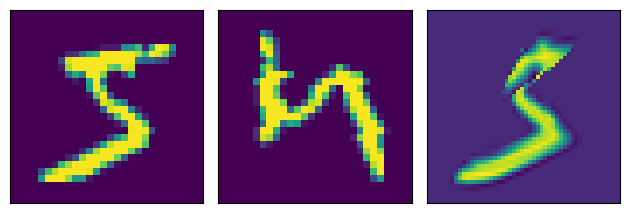

In [25]:
# now lets see what the transform is
# at this point v_net should be optimized
gridsize = int(x.shape[0] ** (1/2))
# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1
# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bicubic_interpolation(CT, z_inv_T).view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, rotated_img, CT_z_inv_T]
plot(imgs)

CT_z_inv_T

In [30]:
gridsize = 28
# Make grid
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)

# Relabel
CR = img
CT = rotated_img

input_dim = 3  # (x, y, t) for 2D image
hidden_dim = 64
output_dim = 2  # (vx, vy) for 2D velocity field
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(v_net.parameters(), lr=0.005)

num_epochs = 350
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    loss = loss_function(v_net, x, CR, CT)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.10428507626056671
Epoch 1, Loss: 0.09373781830072403
Epoch 2, Loss: 0.08322972804307938
Epoch 3, Loss: 0.0749550387263298
Epoch 4, Loss: 0.07109463214874268
Epoch 5, Loss: 0.0667431503534317
Epoch 6, Loss: 0.06529417634010315
Epoch 7, Loss: 0.06176682934165001
Epoch 8, Loss: 0.06255518645048141
Epoch 9, Loss: 0.06366120278835297
Epoch 10, Loss: 0.0635187104344368
Epoch 11, Loss: 0.05985426902770996
Epoch 12, Loss: 0.057262927293777466
Epoch 13, Loss: 0.05420594662427902
Epoch 14, Loss: 0.054541558027267456
Epoch 15, Loss: 0.05548130348324776
Epoch 16, Loss: 0.05407758802175522
Epoch 17, Loss: 0.05414002388715744
Epoch 18, Loss: 0.05368074029684067
Epoch 19, Loss: 0.05371492728590965
Epoch 20, Loss: 0.05320531502366066
Epoch 21, Loss: 0.05259547755122185
Epoch 22, Loss: 0.05187276005744934
Epoch 23, Loss: 0.051420118659734726
Epoch 24, Loss: 0.05136704817414284
Epoch 25, Loss: 0.05090237036347389
Epoch 26, Loss: 0.04982915148139
Epoch 27, Loss: 0.049417801201343536
Epoc

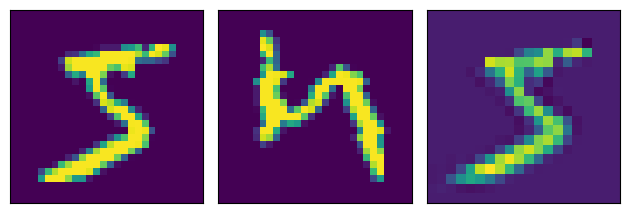

In [34]:
# now lets see what the transform is
# at this point v_net should be optimized
gridsize = int(x.shape[0] ** (1/2))
# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1
# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bicubic_interpolation(CT, z_inv_T).view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, rotated_img, CT_z_inv_T]
plot(imgs)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

class VelocityFieldNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        t_expOutsanded = t.expand_as(x[:, :1])
        x = torch.cat([x, t_expOutsanded], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def bicubic_interpolation(image, coords, device):
    grid = coords.unsqueeze(0).unsqueeze(0).to(device)
    interpolated = nn.functional.grid_sample(image.unsqueeze(0).to(device), grid, mode='bicubic', align_corners=True)
    return interpolated.squeeze()

def loss_function(v_net, x, CR, CT, device):
    gridsize = int(x.shape[0] ** (1/2))
    def odefunc(t, z):
        return v_net(z, t)
    t = torch.tensor([0.0, 1.0], device=device)
    z_T = odeint(odefunc, x, t)[-1]
    def inv_odefunc(t, z):
        return -v_net(z, t)
    z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0]
    CT_z_inv_T = bicubic_interpolation(CT, z_inv_T, device).view(1, gridsize, gridsize).transpose(1, 2)
    CR_x = bicubic_interpolation(CR, x, device).view(1, gridsize, gridsize).transpose(1, 2)
    loss = 0.5 * torch.mean((CT_z_inv_T - CR_x) ** 2)
    return loss

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gridsize = 100
x = torch.stack(torch.meshgrid(torch.linspace(-1,1,gridsize), torch.linspace(-1,1,gridsize)), dim=-1).reshape(-1,2).to(device)
CR = img.to(device)  # Assuming 'img' is already loaded
CT = rotated_img.to(device)  

input_dim = 3
hidden_dim = 64
output_dim = 2
v_net = VelocityFieldNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(v_net.parameters(), lr=0.005)

num_epochs = 400
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(v_net, x, CR, CT, device)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.10155021399259567
Epoch 1, Loss: 0.07926013320684433
Epoch 2, Loss: 0.06769002228975296
Epoch 3, Loss: 0.06065751984715462
Epoch 4, Loss: 0.06031694635748863
Epoch 5, Loss: 0.05748371407389641
Epoch 6, Loss: 0.05464289337396622
Epoch 7, Loss: 0.055007096379995346
Epoch 8, Loss: 0.05418508127331734
Epoch 9, Loss: 0.054238706827163696
Epoch 10, Loss: 0.054231222718954086
Epoch 11, Loss: 0.05391547083854675
Epoch 12, Loss: 0.053481779992580414
Epoch 13, Loss: 0.05319969356060028
Epoch 14, Loss: 0.053056396543979645
Epoch 15, Loss: 0.05281092971563339
Epoch 16, Loss: 0.05243708938360214
Epoch 17, Loss: 0.05212044715881348
Epoch 18, Loss: 0.0519464947283268
Epoch 19, Loss: 0.05169045180082321
Epoch 20, Loss: 0.051216527819633484
Epoch 21, Loss: 0.05057082325220108
Epoch 22, Loss: 0.050308968871831894
Epoch 23, Loss: 0.050387848168611526
Epoch 24, Loss: 0.050189316272735596
Epoch 25, Loss: 0.0498000793159008
Epoch 26, Loss: 0.04971156641840935
Epoch 27, Loss: 0.0495870821177

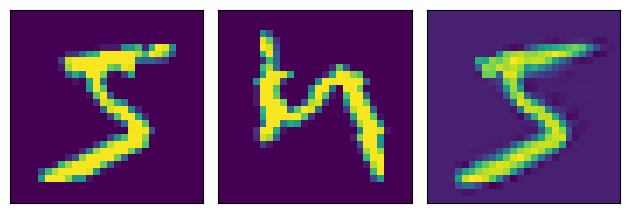

In [43]:
# now lets see what the transform is
# at this point v_net should be optimized
v_net = v_net.to('cpu')
gridsize = img.shape[1]
# Make grid
x = torch.stack(torch.meshgrid(
    torch.linspace(-1,1,gridsize),
    torch.linspace(-1,1,gridsize),
), dim=-1).reshape(-1,2)
# Solve the ODE
def odefunc(t, z):
    return v_net(z, t)
t = torch.tensor([0.0, 1.0]) 
z_T = odeint(odefunc, x, t)[-1] # Take the solution at t=1
# Solve the inverse ODE
def inv_odefunc(t, z):
    return -v_net(z, t)
z_inv_T = odeint(inv_odefunc, z_T, torch.flip(t, dims=[0]))[0] #take the solution at t=0
CT_z_inv_T = bicubic_interpolation(CT, z_inv_T, device='cpu').view(1, gridsize, gridsize).transpose(1,2)

imgs = [img, rotated_img, CT_z_inv_T]
plot(imgs)